In [1]:
import pickle
import numpy as np
import pandas as pd

In [2]:
raw = pd.read_pickle('cleaned_over400000_total191278_data.pickle')
raw = raw.loc[(raw['area_path'].str.contains('Version Control'))]

In [8]:
def get_area(area):
    areas = area.split('\\')
    return '\\'.join(areas[0:4])
raw['area_path'] = raw['area_path'].apply(lambda x: get_area(x))
raw = raw.loc[(raw['area_path'].str.contains('VC'))]

In [9]:
raw.groupby('area_path').count()

,id,area_id,type,text
area_path,,,,
VSOnline\VSTS\Version Control\VC Desktop,6650,6650,6650,6650
VSOnline\VSTS\Version Control\VC Server,1378,1378,1378,1378
VSOnline\VSTS\Version Control\VC Workflows,7587,7587,7587,7587


In [10]:
import re
from nltk.stem import SnowballStemmer

def remove_numbers(words):
    return re.sub(r'\w*\d\w*', '', words).strip()


def reduce_lengthening(text):
    """
    Replace repeated character sequences of length 3 or greater with sequences
    of length 3.
    """
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1\1", text)

stemmer = SnowballStemmer('english')
def stem_words(text):
    words = text.split()
    words = [stemmer.stem(w) for w in words]
    return ' '.join(words)


raw['text2'] = raw['text'].apply(lambda x: remove_numbers(x))
raw['text2'] = raw['text2'].apply(lambda x: reduce_lengthening(x))
raw['text2'] = raw['text2'].apply(lambda x: stem_words(x))

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(raw,test_size=0.2)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=True,max_df=0.9,strip_accents='ascii')
vectorizer.fit(train['text2'])
len(vectorizer.get_feature_names())

12483

In [12]:
!pip install yellowbrick

In [13]:
from yellowbrick.text import TSNEVisualizer

In [14]:
tsne_sample = train.sample(200)

In [18]:
docs = vectorizer.transform(tsne_sample['text2'])

In [19]:
labels = tsne_sample['area_path']

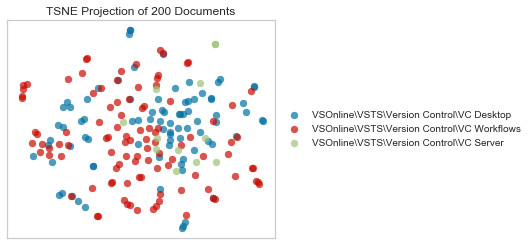

In [20]:
tsne = TSNEVisualizer()
tsne.fit(docs, labels)
tsne.poof()

In [28]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import SGDClassifier

In [29]:
nb = SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [31]:
le=LabelEncoder()

In [32]:
y_train = le.fit_transform(train['area_path'])
y_test = le.transform(test['area_path'])
X_train = vectorizer.transform(train['text2'])
X_test = vectorizer.transform(test['text2'])

In [33]:
from sklearn import metrics
nb.fit(X_train, y_train)
predicted = nb.predict(X_test)
print(metrics.classification_report(y_test, predicted, target_names=le.classes_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


                                            precision    recall  f1-score   support

  VSOnline\VSTS\Version Control\VC Desktop       0.88      0.86      0.87      1305
   VSOnline\VSTS\Version Control\VC Server       0.79      0.63      0.70       279
VSOnline\VSTS\Version Control\VC Workflows       0.87      0.92      0.89      1539

                               avg / total       0.87      0.87      0.87      3123



In [34]:
fn = vectorizer.get_feature_names()
for i, label in enumerate(le.classes_):
    top10 = np.argsort(nb.coef_[i])[-50:]
    top_words = []
    for k in reversed(top10):
        top_words.append(fn[k])
    print("%s: %s" % (label, " ".join(top_words)))
    print()

VSOnline\VSTS\Version Control\VC Desktop: intelli connect gvfs studio git window scc tee solut checkout te gcm clone directori explor verb annot visual cbfs stage rebas java arr publish tenet upstream fast core screenshot hybrid team simul open loos pixel johnmo instal ucr articl start mount exe packag enumer sync investig vscom function loop modern

VSOnline\VSTS\Version Control\VC Server: cv expert odb proxi bitmap ssh tbl workspac dts tfsconfig server trun hour enforc prc destroy repack except secret counter incid gb partner changeset cx stakehold reduct db tfvc vsid main collect agent limit rang blob pend label eldo timeout vc host servic metric prem databas audit pk statist size

VSOnline\VSTS\Version Control\VC Workflows: pr polici pull comment review workflow request overlap fabric pullrequest signal complet access artifact work discuss iter flow cf hotfix action vcw contribut cti picker data link markdown vertic compon mseng signalr shown aria anon anonym power email browser ux